In [ ]:
!pip install python-igraph

     |████████████████████████████████| 3.2 MB 8.9 MB/s 


In [ ]:
import igraph
import numpy as np


def shrink_graph(rx: list, ry: list):
    """
    Utility to help the computation of lines that will depict the relevances over the graph

    :param rx:
    :param ry:
    :return:
    """

    rx = np.array(rx)
    ry = np.array(ry)
    
    if rx[0] == rx[1] == rx[2] and ry[0] == ry[1] == ry[2]:
        rx = rx[0]+0.1*np.cos(np.linspace(0, 2*np.pi, 50))
        ry = ry[0]+0.1*np.sin(np.linspace(0, 2*np.pi, 50))
    else:
        rx = 0.75*rx+0.25*rx.mean()
        ry = 0.75*ry+0.25*ry.mean()
        
        rx = np.concatenate([
                np.linspace(rx[0], rx[0], 41),
                np.linspace(rx[0], rx[1], 20),
                np.linspace(rx[1], rx[2], 20),
                np.linspace(rx[2], rx[2], 41), ])
        ry = np.concatenate([
                np.linspace(ry[0], ry[0], 41),
                np.linspace(ry[0], ry[1], 20),
                np.linspace(ry[1], ry[2], 20),
                np.linspace(ry[2], ry[2], 41)])

        filt = np.exp(-np.linspace(-2, 2, 41)**2)
        filt = filt / filt.sum()

        rx = np.convolve(rx, filt, mode='valid')
        ry = np.convolve(ry, filt, mode='valid')

    return rx, ry


def compute_walks(adj_matrix: np.ndarray):
    """
    Compute all walks of length 3

    :param adj_matrix: Adjacency matrix of graph
    :return:
    """

    w = []

    for v1 in np.arange(len(adj_matrix)):
        for v2 in np.where(adj_matrix[v1])[0]:
            for v3 in np.where(adj_matrix[v2])[0]:

                w += [(v1, v2, v3)]

    return w


def set_graph_layout(adj_matrix: np.ndarray, seed):
    """
    Creates a graph and sets the graph layout according to a set of edges and nodes in adj_matrix

    :param adj_matrix: Adjacency matrix
    :param seed: Random seed of graph
    :return:
    """

    graph = igraph.Graph()
    graph.add_vertices(len(adj_matrix))
    graph.add_edges(zip(*np.where(adj_matrix == 1)))

    return np.array(list(graph.layout_kamada_kawai()))

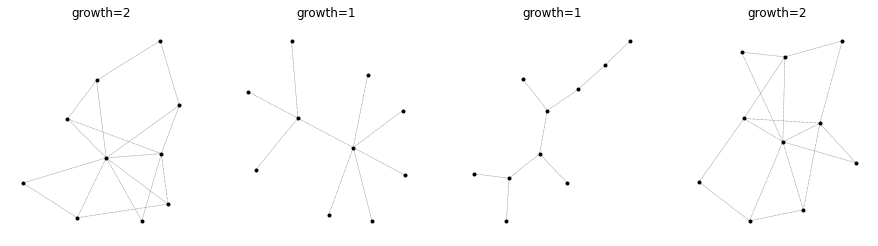

Training model:
   iter | err
   -----------
       0 0.500
    1000 0.486
    2000 0.248
    3000 0.103
    4000 0.043
    5000 0.020
    6000 0.011
    7000 0.008
    8000 0.006
    9000 0.005
   10000 0.006
   11000 0.005
   12000 0.006
   13000 0.005
   14000 0.004
   15000 0.005
   16000 0.005
   17000 0.004
   18000 0.005
   19000 0.005
   20000 0.005
For 200 test sample graphs, the model predicts the growth parameter with an accuracy of 100.0 %


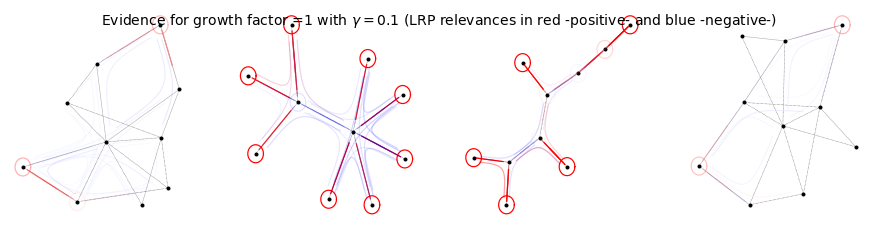

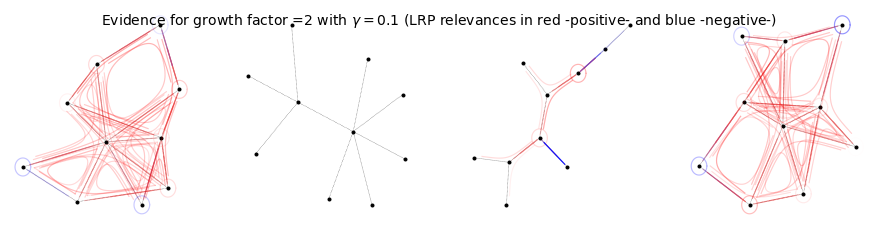

In [ ]:
import random
import sys

import igraph
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch


########################################################################################################################
# [A.] Create example graphs and plots thereof =========================================================================
########################################################################################################################
def create_scale_free_graph(nodes_nr: int, input_seed: int = 0, embed: bool = False, growth=None):
    """
    # Method creates Barabasi-Albert graphs

    :param nodes_nr: Number of graph nodes
    :param input_seed: Seed for the random generation
    :param embed: Parameter that will be used for visualization
    :param growth: Growth parameter of the Barabasi-Albert (BA) graph. The BA graph increases over time. At each 
    timestep a new node with "growth" number of links that connect the new node to "growth" number of nodes already 
    in the network is added.
    :return:
    """

    # [1.] Define number of nodes and the adjacency matrix -------------------------------------------------------------
    adj_matrix = np.zeros([nodes_nr, nodes_nr])     # Adjacency Matrix
    adj_matrix[1, 0] = 1
    adj_matrix[0, 1] = 1

    # The BA graph is a graph that increases over time. At each timestep a new node with "growth" number of links that - 
    # connect the new node to "growth" number of nodes already in the network is added ---------------------------------
    random = np.random.mtrand.RandomState(input_seed)
    growth = growth if growth is not None else random.randint(1, 3)
    N0 = 2

    # [2.] Create the edges according to the growth parameter ----------------------------------------------------------
    for i in range(N0, nodes_nr):
        if growth == 1 : tt = 1     # Barabasi-Albert 1
        elif growth == 2 : tt = 2   # Barabasi-Albert 2
        else:
            tt = 1 + 1*((growth-1) > random.uniform(0, 1))

        p = adj_matrix.sum(axis=0)/adj_matrix.sum()

        for j in random.choice(nodes_nr, tt, p=p, replace=False):
            adj_matrix[i, j] = 1
            adj_matrix[j, i] = 1

    r = random.permutation(len(adj_matrix))
    adj_matrix = adj_matrix[r][:, r]*1.0

    # [3.] Add Self-Connections in the Adjacency matrix ----------------------------------------------------------------
    adj_matrix = adj_matrix + np.identity(len(adj_matrix))

    # [4.] Compute Laplacian of the graph ------------------------------------------------------------------------------
    D = adj_matrix.sum(axis=1)
    laplacian_matrix = torch.FloatTensor(adj_matrix/(np.outer(D, D)**.5+1e-9))

    # [5.] Compute the graph information data structure (dictionary) ---------------------------------------------------
    return {
        'adjacency': torch.FloatTensor(adj_matrix),
        'laplacian': laplacian_matrix,
        'target': growth,
        'layout': set_graph_layout(adj_matrix, input_seed) if embed else None,
        'walks': compute_walks(adj_matrix)
    }


def visualize_graph(graph_data_structure: dict, ax):
    """
    Function to visualise a graph

    :param graph_data_structure: Graph information data structure (dictionary)
    :param ax: Axis
    :return:
    """

    # [1.] Arrange graph layout for plot -------------------------------------------------------------------------------
    r = graph_data_structure['layout']
    r = r - r.min(axis=0)
    r = r / r.max(axis=0) * 2 - 1

    # [2.] Plot the edges ----------------------------------------------------------------------------------------------
    nodes_nr = len(graph_data_structure['adjacency'])
    for i in np.arange(nodes_nr):
        for j in np.arange(nodes_nr):
            if graph_data_structure['adjacency'][i, j] > 0 and i != j: plt.plot([r[i, 0], r[j, 0]], [r[i, 1], r[j, 1]],
                                                                                color='gray',
                                                                                lw=0.5,
                                                                                ls='dotted')

    # [3.] Plot the nodes ----------------------------------------------------------------------------------------------
    ax.plot(r[:, 0], r[:, 1], 'o', color='black', ms=3)


# Plot some example graphs ---------------------------------------------------------------------------------------------
sample_ids = [1, 3, 4, 5]
nodes_nr = 10

plt.figure(figsize=(3 * len(sample_ids), 3))
for ids, seed in enumerate(sample_ids):

    ax = plt.subplot(1, len(sample_ids), ids + 1)
    example_graph = create_scale_free_graph(nodes_nr, input_seed=seed, embed=True)

    visualize_graph(example_graph, ax=ax)
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

    plt.axis('off')
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    ax.set_title(f"growth={example_graph['target']}")

plt.show()
plt.close()


########################################################################################################################
# [B.] Create GraphNet GNN ::: Define architecture, forward and lrp methods ============================================
########################################################################################################################
class GraphNet:
    """
    Graph Net GNN

    The adjacency matrix is not enough in general. Graph nodes do have features 
    (think of values representing size, color and so on) and edges also having 
    corresponding ones (distance, weight...). So only in this case, this very 
    simple graph where in principle only connectivity is used for the 
    classification, the adjacency matrix is enough.

    """

    def __init__(self, input_layer_size: int, hidden_layer_size: int, output_layer_size: int):
        """
        GNN init architecture

        :param input_layer_size: Input layer size
        :param hidden_layer_size: Hidden layer size
        :param output_layer_size: Output layer size
        """

        # [1.] Architecture of the GNN ---------------------------------------------------------------------------------
        self.U = torch.nn.Parameter(torch.FloatTensor(np.random.normal(0, input_layer_size ** -.5,
                                                                       [input_layer_size, hidden_layer_size])))
        self.W1 = torch.nn.Parameter(torch.FloatTensor(np.random.normal(0, hidden_layer_size ** -.5,
                                                                        [hidden_layer_size, hidden_layer_size])))
        self.W2 = torch.nn.Parameter(torch.FloatTensor(np.random.normal(0, hidden_layer_size ** -.5,
                                                                        [hidden_layer_size, hidden_layer_size])))
        self.V = torch.nn.Parameter(torch.FloatTensor(np.random.normal(0, hidden_layer_size ** -.5,
                                                                       [hidden_layer_size, output_layer_size])))

        # [2.] Parameters of the GNN -----------------------------------------------------------------------------------
        self.params = [self.U, self.W1, self.W2, self.V]

    def forward_pass(self, adj_matrix: torch.Tensor):
        """
        Forward pass of the GNN

        :param adj_matrix: Adjacency matrix of the GNN
        :return:
        """

        H = torch.eye(len(adj_matrix))
        H = H.matmul(self.U).clamp(min=0)
        H = (adj_matrix.transpose(1, 0).matmul(H.matmul(self.W1))).clamp(min=0)
        H = (adj_matrix.transpose(1, 0).matmul(H.matmul(self.W2))).clamp(min=0)
        H = H.matmul(self.V).clamp(min=0)

        return H.mean(dim=0)

    def lrp_computation(self, adj_matrix: torch.Tensor, gamma: float, target: int, indexes: tuple):
        """
        Compute the LRP relevance

        :param adj_matrix: Adjacency matrix
        :param gamma: LRP gamma hyperparameter
        :param target: Target class
        :param indexes: Indexes of walk
        :return:
        """

        # [1.]
        if indexes is not None:

            j, k = indexes
            M_j = torch.FloatTensor(np.eye(len(adj_matrix))[j][:, np.newaxis])
            M_k = torch.FloatTensor(np.eye(len(adj_matrix))[k][:, np.newaxis])

        # [2.] Weight parameters of GNN, weighted sum with gamma -------------------------------------------------------
        W1p = self.W1 + gamma * self.W1.clamp(min=0)
        W2p = self.W2 + gamma * self.W2.clamp(min=0)
        Vp = self.V + gamma * self.V.clamp(min=0)

        # [3.] Autograd ------------------------------------------------------------------------------------------------
        X = torch.eye(len(adj_matrix))
        X.requires_grad_(True)

        H = X.matmul(self.U).clamp(min=0)   # 1st layer ----------------------------------------------------------------

        # [4.] --- W1 --------------------------------------------------------------------------------------------------
        Z = adj_matrix.transpose(1, 0).matmul(H.matmul(self.W1))
        Zp = adj_matrix.transpose(1, 0).matmul(H.matmul(W1p))
        H = (Zp * (Z / (Zp + 1e-6)).data).clamp(min=0)

        if indexes is not None: H = H * M_j + (1 - M_j) * (H.data)

        # [5.] --- W2 --------------------------------------------------------------------------------------------------
        Z = adj_matrix.transpose(1, 0).matmul(H.matmul(self.W2))
        Zp = adj_matrix.transpose(1, 0).matmul(H.matmul(W2p))
        H = (Zp * (Z / (Zp + 1e-6)).data).clamp(min=0)

        if indexes is not None: H = H * M_k + (1 - M_k) * (H.data)

        # [6.] --- V ---------------------------------------------------------------------------------------------------
        Z = H.matmul(self.V)
        Zp = H.matmul(Vp)
        H = (Zp * (Z / (Zp + 1e-6)).data).clamp(min=0)

        # [7.] --- Y ---------------------------------------------------------------------------------------------------
        Y = H.mean(dim=0)[target]
        Y.backward()

        return X.data * X.grad


########################################################################################################################
# [C.] Train GNN model =================================================================================================
########################################################################################################################
def train_gnn_model():
    """
    Train the GNN model

    :return:
    """

    # [1.] Train the model with size of input layer: 10, size of hidden layer: 64, size of output layer: 2 -------------
    hidden_layer_size = 64
    output_layer_size = 2
    gnn_model = GraphNet(nodes_nr, hidden_layer_size, output_layer_size)

    optimizer = torch.optim.SGD(gnn_model.params, lr=0.001, momentum=0.99)  # Use SGD optimizer ------------------------
    erravg = 0.5

    print('Training model:')
    print('   iter | err')
    print('   -----------')

    train_iterations = 20001

    for iteration in range(0, train_iterations):
        optimizer.zero_grad()

        # [2.] Create a new scale-free graph ---------------------------------------------------------------------------
        input_graph = create_scale_free_graph(nodes_nr, input_seed=iteration, embed=False)

        # [3.] Forward the input graph's laplacian to the model --------------------------------------------------------
        y = gnn_model.forward_pass(input_graph['laplacian'])

        # [4.] Compute the error between the true value and the predicted one ------------------------------------------
        err = (y[0]-(input_graph['target'] == 1)*1.0)**2 + (y[1]-(input_graph['target'] == 2)*1.0)**2
        erravg = 0.999*erravg + 0.001*err.data.numpy()

        # [5.] Backpropagate a weighted sum of the average error and the currently computed error ----------------------
        err.backward()
        optimizer.step()

        # [6.] Print the error at each iteration -----------------------------------------------------------------------
        if iteration % 1000 == 0:
            print('% 8d %.3f' % (iteration, erravg))

    return gnn_model


model = train_gnn_model()

########################################################################################################################
# [D.] Test GNN model ==================================================================================================
########################################################################################################################
test_size = 200
num_false = 0

# Create new graphs for the test set -----------------------------------------------------------------------------------
for it in range(20001, 20001 + test_size):

    test_graph = create_scale_free_graph(nodes_nr, input_seed=it, embed=False)
    y = model.forward_pass(test_graph['laplacian'])
    prediction = int(y.data.argmax()) + 1

    if prediction != test_graph['target'] : num_false += 1

print('For {} test sample graphs, the model predicts the growth parameter with an accuracy of {} %'.
      format(test_size, 100 * (test_size - num_false)/test_size))


########################################################################################################################
# [E.] Explain and plot relevances =====================================================================================
########################################################################################################################
def explain_graph_LRP(input_graph: dict, nn: GraphNet, target: int, gamma=None, ax=None):
    """
    Explain a graph prediction through GNN-LRP

    :param input_graph: Dictionary of input graph information
    :param nn: GNN
    :param target: target class
    :param gamma: LRP gamma hyperparameter
    :param ax: Plot axis
    :return:
    """

    # [1.] Plot the underlying graph in black --------------------------------------------------------------------------
    r = input_graph['layout']
    r = r - r.min(axis=0)
    r = r / r.max(axis=0) * 2 - 1

    N = len(input_graph['adjacency'])
    for i in np.arange(N):
        for j in np.arange(N):
            if input_graph['adjacency'][i, j] > 0 and i != j: plt.plot([r[i, 0], r[j, 0]], [r[i, 1], r[j, 1]],
                                                                       color='gray',
                                                                       lw=0.5,
                                                                       ls='dotted')
    ax.plot(r[:, 0], r[:, 1], 'o', color='black', ms=3)

    # [2.] For all walks of length 3 compute and plot the relevances ---------------------------------------------------
    for (i, j, k) in input_graph['walks']:

        R = nn.lrp_computation(input_graph['laplacian'], gamma, target, (j, k))[i].sum()
        tx, ty = shrink_graph([r[i, 0], r[j, 0], r[k, 0]], [r[i, 1], r[j, 1], r[k, 1]])

        # Positive (red) or negative (blue) relevance defines the explanation colorbar ----------------------------------------------------------
        # Depending on the intensity of the relevance, define the transparency parameter alpha -------------------------
        if R > 0.0:
            alpha = np.clip(20 * R.data.numpy(), 0, 1)
            ax.plot(tx, ty, alpha=alpha, color='red', lw=1.2)

        if R < -0.0:
            alpha = np.clip(-20 * R.data.numpy(), 0, 1)
            ax.plot(tx, ty, alpha=alpha, color='blue', lw=1.2)


########################################################################################################################
# Generate new graph - new test sample ---------------------------------------------------------------------------------
# Pass this example through the GNN and compute the relevance of the paths of this graph -------------------------------
#
# Red denotes positive relevance/contribution to the predicted class, even if it's a wrong prediction ------------------
# Blue denotes negative relevance/contribution to the predicted class, even it it's a wrong prediction -----------------
########################################################################################################################
gamma = 0.1

for target in [0, 1]:

    plt.figure(figsize=(3 * len(sample_ids), 3))

    for ids, seed in enumerate(sample_ids):
        ax = plt.subplot(1, len(sample_ids), ids + 1)
        example_graph = create_scale_free_graph(nodes_nr, input_seed=seed, embed=True)

        # Explain with LRP ---------------------------------------------------------------------------------------------
        explain_graph_LRP(example_graph, model, target, gamma=gamma, ax=ax)
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

        plt.axis('off')
        plt.xlim(-1.2, 1.2)
        plt.ylim(-1.2, 1.2)

    plt.suptitle(f"Evidence for growth factor ={target + 1} with $\gamma={gamma}$ (LRP relevances in red -positive- and blue -negative-)", size=14)
    plt.show()
    plt.close()
